# Data Wrangling |  Modeling Spotify album popularity
## Leo Evancie, Springboard Data Science Career Track

This is the first step in a capstone project to model album popularity on Spotify, a popular music streaming service. Further project details and rationale can be found in the document 'Proposal.pdf'.

Note: This notebook makes use of <i>Spotipy</i>, a Python library designed for Spotify API calls. I referred to the Medium article "<a href="https://medium.com/@maxtingle/getting-started-with-spotifys-api-spotipy-197c3dc6353b">Getting Started with Spotify's API & Spotipy</a>" by Max Tingle (2019), as well as the <a href="https://spotipy.readthedocs.io/en/latest/#"><i>Spotipy</i> documentation.</a>

### 1. Data collection

First, import the relevant libraries:

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from dotenv import load_dotenv

Load my Spotify developer credentials, stored as environmental variables. Instantiate the Spotify API client.

In [2]:
load_dotenv()
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

Retrieve a sampling of 20 albums (the default response limit) from the year 2021 to get a sense of the response structure.

In [3]:
album_results = sp.search(q='year:2021', type='album')

In [4]:
type(album_results)

dict

In [5]:
album_results['albums']['items'][0].keys()

dict_keys(['album_type', 'artists', 'available_markets', 'external_urls', 'href', 'id', 'images', 'name', 'release_date', 'release_date_precision', 'total_tracks', 'type', 'uri'])

I notice that `popularity` is not listed among the returned data. This is the variable I want my model to predict. Let's try a search for individual tracks instead.

In [6]:
track_results = sp.search(q='year:2021', type='track')
track_results = track_results['tracks']['items']
track_results[0].keys()

dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])

Bingo. I see that I will need to search for a large quantity of tracks, rather than albums, in order to develop a model for predicting popularity. As such, I can expect that `album` and `artists` will heavily influence popularity. Hopefully, I can identify plenty of other influential features; an artist can't change their identity in the hope of boosting their music's popularity score!

I'll look at the sample results in a DataFrame to get a clearer picture of the values. I will choose only those variables that seem relevant to the question at hand. For example, I will exclude `preview_url`, and other references, keeping `track_id` as a unique identifier.

In [7]:
track_id = []
name = []
artist_name = []
popularity = []
duration_ms = []
explicit = []
track_number = []
available_markets = []
disc_number = []
album_type = []

for track in track_results:
    track_id.append(track['id'])
    name.append(track['name'])
    artist_name.append(track['artists'][0]['name'])
    popularity.append(track['popularity'])
    duration_ms.append(track['duration_ms'])
    explicit.append(track['explicit'])
    track_number.append(track['track_number'])
    available_markets.append(track['available_markets'])
    disc_number.append(track['disc_number'])
    album_type.append(track['album']['album_type'])
    
track_df = pd.DataFrame({
    'track_id':track_id,
    'name':name,
    'artist_name':artist_name,
    'popularity':popularity,
    'duration_ms':duration_ms,
    'explicit':explicit,
    'track_number':track_number,
    'disc_number':disc_number,
    'available_markets':available_markets,
    'album_type':album_type
})

track_df

,track_id,name,artist_name,popularity,duration_ms,explicit,track_number,disc_number,available_markets,album_type
0,748mdHapucXQri7IAO8yFK,Kiss Me More (feat. SZA),Doja Cat,99,208866,True,1,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",single
1,08ejYlzduA6O82FJgnFKQz,Year 2020,Leonardo Makno,37,133281,False,2,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",single
2,0UsmyJDsst2xhX1ZiFF3JW,"Year,2015",Schoolgirl Byebye,25,74301,False,1,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",single
3,0koiLB5LKB5fXOuZKNmQvc,King,Years & Years,0,214834,False,19,1,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, B...",album
4,6PERP62TejQjgHu81OHxgM,good 4 u,Olivia Rodrigo,98,178147,True,1,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",single
5,3wLWURwOlQZ7O3VWcV4BJJ,Ingrato amor - Live Streaming audio and video ...,Amaranta,5,352647,False,13,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",album
6,7BFk1nSfwfkDOgnNNeY7Yn,wish i dropped out like brakence interlude,Satoshi Love,0,83000,False,4,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",album
7,5BJs3aDrKYBRkzrhaVxf89,After Me - 2021 Version,Saliva,47,234288,False,3,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",single
8,43PGPuHIlVOc04jrZVh9L6,RAPSTAR,Polo G,95,165925,True,1,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",single
9,6EPUCU04NW6c9eCwfTcxIQ,Medley Picaflor de Los Andes - Live Streaming ...,Amaranta,7,1035420,False,3,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",album


A few questions occur to me at this stage. What is to be made of the `available_markets` field? Are most songs available in the same large set of markets, or perhaps one of a few groups of markets, or is there greater variation?

Also, I see that one sampled track contains a feature, as included in the track name, "Kiss Me More (feat. SZA)." I could use a bit of string analysis to create a new Boolean field, `feature`, in case the presence of a featured artist has some bearing on popularity.

Perhaps most importantly, several of the sampled tracks have a `popularity` score of zero. What accounts for zero popularity? Is it a missing value, and/or due to being quite new on the platform? I will need to do some serious thinking about how to handle such scores in my analysis.

Meanwhile, I do not have enough continuous variables to build an effective model. Luckily, Spotify also offers an API endpoint for audio features, including quantities like `danceability` and `tempo`. Let's look at a sample response from such a search. I'll use a `track_id` from the above DataFrame.

In [11]:
sample_audio_feature = sp.audio_features(track_df['track_id'][0])
sample_audio_feature

[{'danceability': 0.762,
  'energy': 0.701,
  'key': 8,
  'loudness': -3.541,
  'mode': 1,
  'speechiness': 0.0286,
  'acousticness': 0.235,
  'instrumentalness': 0.000158,
  'liveness': 0.123,
  'valence': 0.742,
  'tempo': 110.968,
  'type': 'audio_features',
  'id': '748mdHapucXQri7IAO8yFK',
  'uri': 'spotify:track:748mdHapucXQri7IAO8yFK',
  'track_href': 'https://api.spotify.com/v1/tracks/748mdHapucXQri7IAO8yFK',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/748mdHapucXQri7IAO8yFK',
  'duration_ms': 208867,
  'time_signature': 4}]

Now that I know how to retrieve all the fields I want, as well as how to convert my search results into a DataFrame, I will generate my full dataset. Spotify's search API allows for a maximum offset of 1,000 for their API search calls, with a maximum 50 records per call. I probably need about ten times that number of tracks for my model. I will thus execute the search 10 times, each for a different year. (This will introduce the possibility that the release year itself might affect popularity; maybe audiences respond to different aspects of music in different eras.) After retrieving each batch of 50 tracks, I will feed those into the `sp.audio_features` search, storing all relevant results as I go.

In [8]:
#initializing empty lists, which will become DataFrame columns
track_id = []
name = []
artist_name = []
year = []
popularity = []
duration_ms = []
explicit = []
track_number = []
available_markets = []
disc_number = []
album_type = []
danceability = []
energy = []
loudness = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []
time_signature = []

#looping through the years 2012 through 2021:
for yr in range(2012,2022):
    #due to search API constraints, searching for chunks of 50 tracks up to 1000 total for the given year:
    for i in range(0,1000,50):
        track_results = sp.search(q='year:{}'.format(yr), type='track', limit=50, offset=i)
        track_results = track_results['tracks']['items']
        #initialize a list to collect track IDs, to be used in the audio feature search
        track_ids = []
        #appending track info to lists
        for track in track_results:
            track_id.append(track['id'])
            name.append(track['name'])
            artist_name.append(track['artists'][0]['name'])
            popularity.append(track['popularity'])
            duration_ms.append(track['duration_ms'])
            explicit.append(track['explicit'])
            track_number.append(track['track_number'])
            available_markets.append(track['available_markets'])
            disc_number.append(track['disc_number'])
            album_type.append(track['album']['album_type'])
            track_ids.append(track['id'])
            year.append(str(yr))
        #searching for corresponding audio features based on the track IDs from the search above
        feature_results = sp.audio_features(track_ids)
        for feature in feature_results:
            #while debugging, I found that two tracks do not have audio feature data available
            if feature == None:
                danceability.append(np.nan)
                energy.append(np.nan)
                loudness.append(np.nan)
                speechiness.append(np.nan)
                acousticness.append(np.nan)
                instrumentalness.append(np.nan)
                liveness.append(np.nan)
                valence.append(np.nan)
                tempo.append(np.nan)
                time_signature.append(np.nan)
            else:
                danceability.append(feature['danceability'])
                energy.append(feature['energy'])
                loudness.append(feature['loudness'])
                speechiness.append(feature['speechiness'])
                acousticness.append(feature['acousticness'])
                instrumentalness.append(feature['instrumentalness'])
                liveness.append(feature['liveness'])
                valence.append(feature['valence'])
                tempo.append(feature['tempo'])
                time_signature.append(feature['time_signature'])
            
#constructing DataFrame from the now-complete lists
df = pd.DataFrame({
    'track_id':track_id,
    'name':name,
    'artist_name':artist_name,
    'year':year,
    'popularity':popularity,
    'duration_ms':duration_ms,
    'explicit':explicit,
    'track_number':track_number,
    'disc_number':disc_number,
    'available_markets':available_markets,
    'album_type':album_type,
    'danceability':danceability,
    'energy':energy,
    'loudness':loudness,
    'speechiness':speechiness,
    'acousticness':acousticness,
    'instrumentalness':instrumentalness,
    'liveness':liveness,
    'valence':valence,
    'tempo':tempo,
    'time_signature':time_signature
}) 

In [9]:
df.head()

,track_id,name,artist_name,year,popularity,duration_ms,explicit,track_number,disc_number,available_markets,...,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,2iUmqdfGZcHIhS3b9E9EWq,Everybody Talks,Neon Trees,2012,82,177280,False,3,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",...,0.471,0.924,-3.906,0.0586,0.003010,0.000000,0.3130,0.725,154.961,4.0
1,08ejYlzduA6O82FJgnFKQz,Year 2020,Leonardo Makno,2012,37,133281,False,2,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",...,0.805,0.417,-11.722,0.0462,0.508000,0.020100,0.0903,0.548,129.984,4.0
2,52a6VcF23v5HB7KfDEmBHq,Carried Away,Passion Pit,2012,60,221973,False,3,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",...,0.772,0.826,-5.135,0.0344,0.017600,0.000009,0.3830,0.871,119.995,4.0
3,1JIzFhI9Lt5FyslawmHCBi,Five Years - 2012 Remaster,David Bowie,2012,58,283752,False,1,1,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",...,0.460,0.326,-10.699,0.0417,0.142000,0.000010,0.0449,0.321,152.531,3.0
4,0ZFBKLOZLIM16RAUb5eomN,Bubblegum Bitch,MARINA,2012,76,154666,True,1,1,"[CA, US]",...,0.495,0.856,-5.123,0.0311,0.000219,0.000000,0.1030,0.609,158.024,4.0


### 2. Data Organization

Having created a data folder in the project repository, I will save the above DataFrame as a .csv file for the sake of easily accessing the raw data in the future. Later in the project, I will store my training and testing data to develop my model.

In [13]:
#saving to project directory
df.to_csv('./data/raw.csv')

### 3. Data Definition

Now, I will inspect the features of my data to inform next steps. From this point, I will use the term "features" to refer to the columns/variables of the dataset. I will use "audio features" to refer specifically to those quantitative metrics appearing in the latter half of the DataFrame (e.g., `danceability`).

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           10000 non-null  object 
 1   name               10000 non-null  object 
 2   artist_name        10000 non-null  object 
 3   year               10000 non-null  object 
 4   popularity         10000 non-null  int64  
 5   duration_ms        10000 non-null  int64  
 6   explicit           10000 non-null  bool   
 7   track_number       10000 non-null  int64  
 8   disc_number        10000 non-null  int64  
 9   available_markets  10000 non-null  object 
 10  album_type         10000 non-null  object 
 11  danceability       9998 non-null   float64
 12  energy             9998 non-null   float64
 13  loudness           9998 non-null   float64
 14  speechiness        9998 non-null   float64
 15  acousticness       9998 non-null   float64
 16  instrumentalness   9998

In [14]:
df.describe()

,popularity,duration_ms,track_number,disc_number,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,10000.00000,1.000000e+04,10000.000000,10000.00000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000
mean,39.22830,2.241816e+05,11.831400,1.20140,0.591778,0.663778,-7.765715,0.098835,0.225278,0.182922,0.221447,0.464290,122.974357,3.930586
std,31.39288,2.257556e+05,17.696584,0.93484,0.164551,0.232493,4.114215,0.110924,0.289155,0.333510,0.189255,0.243697,27.544550,0.373931
min,0.00000,3.710000e+02,1.000000,1.00000,0.000000,0.000020,-40.449000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.00000,1.688032e+05,2.000000,1.00000,0.483250,0.520250,-9.059750,0.038200,0.007770,0.000000,0.099825,0.270000,102.020000,4.000000
50%,32.00000,2.092465e+05,6.000000,1.00000,0.597000,0.693000,-6.815000,0.054900,0.081250,0.000048,0.136000,0.457000,126.030500,4.000000
75%,70.00000,2.479460e+05,12.000000,1.00000,0.713000,0.856000,-5.237000,0.105000,0.353000,0.130750,0.299000,0.648000,138.030000,4.000000
max,100.00000,1.082819e+07,122.000000,13.00000,0.987000,1.000000,1.060000,0.961000,0.996000,1.000000,0.994000,0.984000,220.099000,5.000000


The `popularity` field has a mean value of 39.23. This is suspiciously low, and I suspect it's due to the large number of 0 values in that column. I'll inspect that column more closely next. Using a <a href="https://count.co/n/OqA2ey7ZvI5"> data dictionary </a> found online, I can glean a bit of context about the less self-explanatory fields here. For example, `valence` is a value from 0.0 to 1.0 measuring "musical positiveness." It is feasible that this could impact `popularity`. 

However, why are these `loudness` values negative, if decibels are practically always positive? A bit of <a href="https://ask.audio/articles/spotify-drops-loudness-target-to-14-lufs-what-does-this-mean-for-producers"> further digging </a> reveals that Spotify reports `loudness` in something called "LUFS" or Loudness Units Full Scale. On this scale, higher negative numbers correspond to louder volumes, with a value of zero relating to the volume that causes audio clipping (i.e., distortion).

NOTE: Add "mode" and "key" back into the search.

Let's visualize the `popularity` field to determine how many zero values we have:

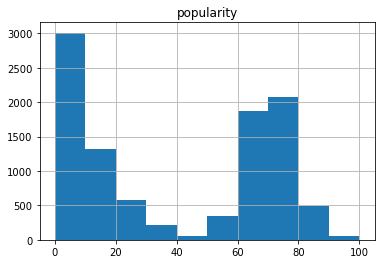

In [22]:
df.hist(column='popularity');

Unfortunately, we have 3,000 songs with a popularity score of zero. This is a huge chunk of our data. When and where do such values occur? Since `popularity` is an instantaneous metric, recent artists most likely have higher scores. Do our values of zero fall disproportionately in the early years?

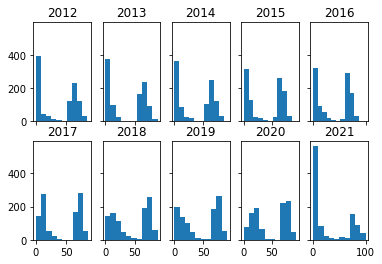

In [50]:
years = (yr for yr in df['year'].unique())
fig, axs = plt.subplots(2, 5, sharey=True, sharex='col')
for r in range(2):
    for c in range(5):
        plotfilter = title = next(years)
        axs[r,c].hist(df[df['year']==plotfilter]['popularity'])
        axs[r,c].set_title(title)

We see bimodal distributions for `popularity` for each year. While the highest `popularity` values do occur in the most recent years, we see plenty of zero values within every year. In fact, zero is the most common value in the majority of years, most drastically so in 2021. Crucially, each year contains at least some clustering of low values <i>besides zero</i>. Since a low non-zero `popularity` score could not possibly represent a missing value, we can conclude that at least some of the zero scores are valid zeroes (not missing values). Whether <i>any</i> of the zero scores reflect missing data is still unclear.